In [ ]:
# You can get more datasets here https://repository.cloudlab.zhaw.ch/artifactory/deepscores/archives/2017/

!wget https://grfia.dlsi.ua.es/primus/packages/CameraPrIMuS.tgz
!wget https://raw.githubusercontent.com/OMR-Research/tf-end-to-end/master/Data/vocabulary_semantic.txt
!wget https://raw.githubusercontent.com/OMR-Research/tf-end-to-end/master/Data/train.txt
!wget https://raw.githubusercontent.com/OMR-Research/tf-end-to-end/master/Data/test.txt

In [ ]:
!tar -xvf CameraPrIMuS.tgz 
#!tar -xvf primusCalvoRizoAppliedSciences2018.tgz 

In [234]:
# Modle is added to my google drive. 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [235]:
import sys
sys.path.append('/content/drive/My Drive/ColabNotebooks/tf-end-to-end_v2')

In [233]:
import torch, torchvision, PIL, numpy as np
import pathlib
import PIL
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
import pandas as pd
import pdb
import numpy as np
import cv2
import random
from tqdm.auto import tqdm
import pdb

In [236]:
class MusicClassificationObject:

  def __init__(self, dataset_dir, dataset_filenames, dictionary_path, transform=None, label_transform=None, distortions=False):
        self.distortions = distortions
        self.dataset_dir = dataset_dir
        self.transform = transform 
        self.label_transform = label_transform

        dataset_filenames = open(dataset_filenames,'r')
        dataset_list = dataset_filenames.read().splitlines()
        dataset_filenames.close()

        self.current_idx = 0
        # Dictionary
        self.symbol2index = {}
        self.index2symbol = {}
            
        dict_file = open(dictionary_path,'r')
        dict_list = dict_file.read().splitlines()
        word_idx = 0

        for word in dict_list:
          self.symbol2index[word] = word_idx
          self.index2symbol[word_idx] = word
          word_idx += 1 

        dict_file.close()

        self.dataset = self.createDataset(dataset_list)
        self.vocabulary_size = len(self.symbol2index)
  
  def createDataset(self, dataset_list):
    dataset = []
    i = 0
    for sample in dataset_list:
      sample_filepath = self.dataset_dir + '/' + sample + '/' + sample
      sample_semantic = sample_filepath + '.semantic'
      sample_gt_file = open(sample_semantic, 'r')
      sample_gt_plain = sample_gt_file.readline().split()
      sample_gt_file.close()
      # (img file name, all the notations sequentially related to the file)
      dataset.append((sample_filepath + '.png', [self.symbol2index[lab] for lab in sample_gt_plain]))
    return dataset

  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, i):
    if torch.is_tensor(i):
        i = i.item()
    imgfn, label = self.dataset[i]
    img = PIL.Image.open(imgfn)
    if self.transform:
        img = self.transform(img)
    return (img.type(torch.FloatTensor), torch.tensor(label))


In [237]:
img_height = 64
xform = torchvision.transforms.Compose([torchvision.transforms.Resize(img_height), torchvision.transforms.ToTensor()])
music_dataset = MusicClassificationObject('Corpus', 'train.txt', 'vocabulary_semantic.txt', xform)

In [238]:
music_dataset[60]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([  10,  231, 1757,  844,    0, 1470,  441, 1646, 1454, 1210,    0, 1461,
          823,  823,    0, 1036, 1225, 1470,    0, 1470, 1225, 1663,    0]))

In [239]:
def show_img(sample, title=None):
    img = sample
    if torch.is_tensor(img):
        img = img.cpu().permute(1,2,0)
    plt.imshow(img[:,:,0])
    if title:
        plt.title(title) # add color='w' arg if using a dark background
    plt.axis('off')

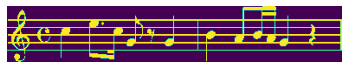

In [240]:
show_img(music_dataset[8][0])

In [241]:
def data_processing(data):
  max_image_width = 2000
  img_channels = 1
  img_height = 64
  image_batches = []
  labels = []
  # Pads the given dataset. 
  for sample, label in data:
    batch_image = torch.ones([img_channels, img_height, max_image_width]).type(torch.FloatTensor)*0
    batch_image[0, :sample.shape[1], :sample.shape[2]] = sample

    image_batches.append(batch_image)
    labels.append(label)
  
  image_batches = nn.utils.rnn.pad_sequence(image_batches, batch_first=True)
  labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

  return image_batches, labels

In [242]:
n_all_det = len(music_dataset)
n_used_det = int(1 * n_all_det)
n_train_det = int(0.8 * n_used_det)
n_test_det = n_used_det - n_train_det
rng_det = torch.Generator().manual_seed(291)
dataset_train, dataset_test, _ = torch.utils.data.random_split(music_dataset, [n_train_det, n_test_det, n_all_det-n_train_det-n_test_det], rng_det)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train,
                                batch_size=16,
                                shuffle=True,
                                collate_fn=lambda x: data_processing(x))
test_loader = torch.utils.data.DataLoader(dataset=dataset_test,
                                batch_size=16,
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x))

In [256]:
from torch.nn import functional as F
from torch import nn

class MusicModel(nn.Module):
  def __init__(self, num_notes):
      super(MusicModel, self).__init__()
      self.conv_1 = nn.Conv2d(1, 128, kernel_size=(3,3), padding=(1,1))
      self.max_pool_1 = nn.MaxPool2d(kernel_size=(2,2))  
      self.conv_2 = nn.Conv2d(128, 64, kernel_size=(3,3), padding=(1,1))
      self.max_pool_2 = nn.MaxPool2d(kernel_size=(2,2))

      self.linear_1 = nn.Linear(1024, 64)
      self.drop_1 = nn.Dropout(0.2) 

      self.gru = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)
      self.output = nn.Linear(64, num_notes + 1)

  def forward(self, images, targets=None):
      bs, c, h, w = images.size()
      #print(bs, c, h, w)
      x = F.relu(self.conv_1(images))
      #print(x.size())
      x = self.max_pool_1(x)
      #print(x.size())
      x = F.relu(self.conv_2(x))
      #print(x.size())
      x = self.max_pool_2(x)
      #print(x.size()) # 1, 64, 32, 75 // b, f, h, w
      # Setup a permutation for the rnn layers
      x = x.permute(0, 3, 1, 2) # 1, 75, 64, 32 // we do this to look at the width of the image
      #print(x.size())
      x = x.view(bs, x.size(1), -1)
      #print(x.size())
      x = self.linear_1(x)
      x = self.drop_1(x)
      #print(x.size())
      x, _ = self.gru(x)
      #print(x.size())
      x = self.output(x)
      #print(x.size())
      x = x.permute(1, 0, 2) # timesteps, batchsize, values -> for CTC must go in this order
      #print(x.size())
      if targets is not None:
          log_softmax_values = F.log_softmax(x, 2)
          input_lengths = torch.full(
              size=(bs, ), fill_value=log_softmax_values.size(0),
              dtype=torch.int32
          )
          #print(input_lengths)
          target_lengths = torch.full(
              size=(bs, ), fill_value=targets.size(1),
              dtype=torch.int32
          )
          #print(target_lengths)
          loss = nn.CTCLoss(blank=0)(
              log_softmax_values, targets, input_lengths, target_lengths
          )
          return x, loss 
      return x, None




In [245]:
mm = MusicModel(music_dataset.vocabulary_size)
img = torch.rand(16, 1, 64, 300)
target = torch.randint(1, 20, (16, 5))
x, loss = mm(img, target)

In [259]:
model = MusicModel(music_dataset.vocabulary_size)

#torch.nn.init.xavier_uniform_(torch.empty(256,256))
device = torch.device('cuda:0')
model.to(device)

MusicModel(
  (conv_1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=1024, out_features=64, bias=True)
  (drop_1): Dropout(p=0.2, inplace=False)
  (gru): GRU(64, 32, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (output): Linear(in_features=64, out_features=1782, bias=True)
)

In [260]:
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=5, verbose=True
    )

In [261]:
from torch.autograd import Variable
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()
gradient_accumulations = 4

def run_test(model, no_preds=False):
    nsamples_test = len(dataset_test)
    loss_total = 0
    sample = None
    model.eval()
    with torch.no_grad():
        for _data in test_loader:
            music_sheet_samples, labels = _data
            music_sheet_samples = music_sheet_samples.to(device)
            labels = labels.to(device)

            output, loss = model(music_sheet_samples, labels)

           # truth_predictions = []
           # for label in labels.detach().cpu().numpy():
           #     pred = [music_dataset.index2symbol[x] for x in label]
           #     truth_predictions.append(pred)
         
            #current_preds = decode_predictions(output)
            
            # Print example predictions labels
            #print(current_preds[1])
            #print(truth_predictions[1])

            loss_total += loss 

    return loss_total / nsamples_test

def run_train(model, opt, sched):
    nsamples_train = len(dataset_train)
    loss_sofar = 0
    model.train()
    with torch.enable_grad():
        i = 0
        for _data in tqdm(train_loader, desc='iters', leave=False):
            music_sheet_samples = Variable(_data[0]) 
            labels = Variable(_data[1])
            music_sheet_samples = music_sheet_samples.to(device)
            labels = labels.to(device)
            opt.zero_grad()

            preds, loss = model(music_sheet_samples, labels)
            #scaler.scale(loss / gradient_accumulations).backward()
      
            loss.backward()

            opt.step()
            model.zero_grad() 

            #if (i + 1) % gradient_accumulations == 0:
            #  scaler.step(opt)
            #  scaler.update()
            #  model.zero_grad()
 
            i += 1
            loss_sofar += loss 
   
    return loss_sofar / nsamples_train

def run_all(model, optimizer, scheduler, n_epochs):
    for epoch in tqdm(range(n_epochs), desc='epochs'):
        loss_train = run_train(model, optimizer, scheduler)
        loss_test = run_test(model, no_preds=True)
        tqdm.write(f"epoch {epoch+1}: train loss {loss_train:.4f}, test loss {loss_test:.4f}")

In [268]:
output = run_all(model, optimizer, scheduler, 10)

epoch 1: train loss 0.1117, test loss 0.0242


epoch 2: train loss 0.0138, test loss 0.0172


epoch 3: train loss 0.0091, test loss 0.0102


epoch 4: train loss -0.0045, test loss -0.0165


epoch 5: train loss -0.0271, test loss -0.0434


epoch 6: train loss -0.0575, test loss -0.0762


epoch 7: train loss -0.0825, test loss -0.0984


epoch 8: train loss -0.0993, test loss -0.1118


epoch 9: train loss -0.1109, test loss -0.1208


epoch 10: train loss -0.1182, test loss -0.1265



In [270]:
# Save our model 
path = "/content/drive/MyDrive/CPEN 291 Project/music_classifer_model.pth" 
torch.save(model.state_dict(), path)

In [276]:
import numpy

def decode_predictions(preds):
    preds = preds.permute(1, 0, 2) # batch-size, timestamps, predictions
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    for p in preds:
      temp = []
      for k in p:
          k = k - 1 
          if (k == -1):
            continue
            #temp.append('-') # our blank symbol for the ctc function
          else:
            temp.append(music_dataset.index2symbol[k])
      cap_preds.append(temp)
    return cap_preds 

In [277]:
sample = None
test_loader_1 = torch.utils.data.DataLoader(dataset=dataset_test,
                                batch_size=3,
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x))
for _data in test_loader_1:
  sample, labels = _data
  break

In [278]:
sample = sample.to(device)
labels = labels.to(device)

In [279]:
output, loss = model(sample, labels)
print(loss)

tensor(-0.7261, device='cuda:0', grad_fn=<MeanBackward0>)


In [290]:
show_img(sample[1])
print(predictions[1])

['clef-F3', 'clef-F3', 'timeSignature-9/8', 'note-D#3_quarter.', 'note-G#3_quarter.', 'note-A#3_quarter.', 'note-A#3_quarter.', 'note-D#4_quarter.', 'note-D#4_quarter.', 'note-C#4_quarter..', 'note-A#3_half.', 'note-A#3_half.', 'note-D#4_quarter.', 'note-A#3_quarter.', 'note-G#3_half.']


In [289]:
# Compare to the ground-truth predictions 
predictions = decode_predictions(output)
idx = 1
truth_predictions = []
for label in labels.detach().cpu().numpy():
  pred = [music_dataset.index2symbol[x] for x in label]
  truth_predictions.append(pred)
print(truth_predictions[idx])
print(predictions[idx])

['clef-F4', 'keySignature-GM', 'timeSignature-C', 'note-D3_quarter', 'barline', 'note-G3_quarter', 'note-A3_quarter', 'note-B3_quarter', 'note-C4_quarter', 'barline', 'note-D4_quarter', 'note-C4_quarter', 'note-B3_half', 'barline', 'note-C4_half', 'note-D4_quarter', 'note-A3_quarter', 'barline', 'note-G3_half.', 'barline', 'barline', 'barline', 'barline', 'barline', 'barline', 'barline', 'barline', 'barline', 'barline', 'barline', 'barline']
['clef-F3', 'clef-F3', 'timeSignature-9/8', 'note-D#3_quarter.', 'note-G#3_quarter.', 'note-A#3_quarter.', 'note-A#3_quarter.', 'note-D#4_quarter.', 'note-D#4_quarter.', 'note-C#4_quarter..', 'note-A#3_half.', 'note-A#3_half.', 'note-D#4_quarter.', 'note-A#3_quarter.', 'note-G#3_half.']
